# plotting functions of supplmentary figure 1 in the manuscript
This figure shows the following:

- Panel showing CTF estimation for the covid spike trimer
- Panel showing ground-truth and estimated poses for covid spike trimer

- Panel showing consensus reconstruction of covid spike monomer
- Panel showing particle picking for covid spike monomer


In [1]:
# imports
import os
import pandas as pd

# roodmus
from roodmus.analysis.utils import load_data
from roodmus.analysis.plot_ctf import plot_defocus_scatter
from roodmus.analysis.plot_alignment import true_pose_distribution_plot, picked_pose_distribution_plot
from roodmus.analysis.plot_picking import plot_recall, plot_precision

In [2]:
# loading covid spike trimer data
project_dir = "/tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA"
config_dir = "/tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA/Micrographs"
# config_dir = os.path.join(project_dir, "Micrographs")
figures_dir = os.path.join(project_dir, "figures")
meta_files = [
    os.path.join(project_dir, "Refine3D", "job008", "run_it011_data.star"),
    os.path.join(project_dir, "Refine3D", "job039", "run_it014_data.star"),
]

jobtypes = {
    os.path.join(project_dir, "Refine3D", "job008", "run_it011_data.star"): "Refine3D_8000",
    os.path.join(project_dir, "Refine3D", "job039", "run_it014_data.star"): "Refine3D_236079",
}

particle_diameter = 100 # approximate particle diameter in Angstroms
ugraph_shape = (4000, 4000) # shape of the micrograph in pixels. Only needs to be given if the metadata file is a .star file
verbose = True # prints out progress statements
ignore_missing_files = True # if .mrc files are missing, the analysis will still be performed
enable_tqdm = True # enables tqdm progress bars

for i, meta_file in enumerate(meta_files):
    if i == 0:
        analysis = load_data(meta_file, config_dir, particle_diameter, ugraph_shape=ugraph_shape, verbose=verbose, enable_tqdm=enable_tqdm, ignore_missing_files=ignore_missing_files) # creates the class
    else:
        analysis.add_data(meta_file, config_dir, verbose=verbose) # updates the class with the next metadata file
    
df_picked = pd.DataFrame(analysis.results_picking)
df_truth = pd.DataFrame(analysis.results_truth)
df_precision, df_picked = analysis.compute_precision(df_picked, df_truth, verbose=verbose)
print(f"mean precision: {df_precision['precision'].mean()}")
print(f"mean recall: {df_precision['recall'].mean()}")


loading metadata from /tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA/Refine3D/job008/run_it011_data.star...
loaded metadata from /tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA/Refine3D/job008/run_it011_data.star. determined file type: star


Dictionaries now contain 8000 reconstructed particles
added 8000 particles from /tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA/Refine3D/job008/run_it011_data.star


loading truth data: 100%|██████████| 900/900 [08:54<00:00,  1.68it/s, micrograph=000899.mrc]


Loaded ground-truth particle positions from config files
Dictionaries now contain 8000 particles and 270000 true particles
Added 270000 particles from /tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/DESRES-Trajectory_sarscov2-11021571-all-glueCA/Micrographs
loading metadata from /tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA/Refine3D/job039/run_it014_data.star...
loaded metadata from /tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA/Refine3D/job039/run_it014_data.star. determined file type: star
checking if ugraphs exist...


Dictionaries now contain 244079 reconstructed particles
added 236079 particles from /tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-

computing precision: 100%|██████████| 1800/1800 [01:07<00:00, 26.82it/s, precision=1, recall=0.913, multiplicity=0.917]      


time taken to compute precision: 67.80442404747009
mean precision: 0.9995124966496581
mean recall: 0.4704822449925868


## panel A
plotting the CTF estimation for the covid spike trimer

saved figure to: /tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA/figures/defocus_scatter.pdf
correlation coefficient: 0.04286525151473806


/tmp/ipykernel_29657/1860664237.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_l.set_xticklabels([f"{-x/1000:.1f}" for x in ax_l.get_xticks()])
/tmp/ipykernel_29657/1860664237.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_r.set_xticklabels([f"{-x/1000:.1f}" for x in ax_r.get_xticks()])
/tmp/ipykernel_29657/1860664237.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_l.set_yticklabels([f"{-x/1000:.1f}" for x in ax_l.get_yticks()])


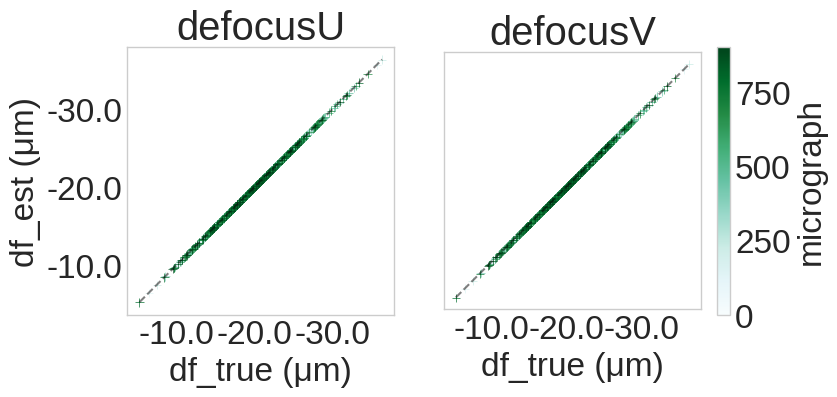

In [4]:
fig, (ax_l, ax_r) = plot_defocus_scatter(
    df_picked=df_picked,
    metadata_filename=meta_files[0],
    df_truth=df_truth,
    palette="BuGn",
)
fig.set_size_inches(4.5*2, 4.5)
# change the xticklabels from Angstrom to um
ax_l.set_xticklabels([f"{-x/1000:.1f}" for x in ax_l.get_xticks()])
ax_r.set_xticklabels([f"{-x/1000:.1f}" for x in ax_r.get_xticks()])
ax_l.set_yticklabels([f"{-x/1000:.1f}" for x in ax_l.get_yticks()])
ax_r.set_aspect("equal")
ax_l.set_aspect("equal")
ax_l.set_xlabel("df_true (\u03bcm)")
ax_l.set_ylabel("df_est (\u03bcm)")
ax_r.set_xlabel("df_true (\u03bcm)")
fig.tight_layout()

# fig.savefig(os.path.join(figures_dir, "defocus_scatter.pdf"), bbox_inches="tight")
print(f"saved figure to: {os.path.join(figures_dir, 'defocus_scatter.pdf')}")

# print the correlation coefficient between the true and estimated defocus values
print(f"correlation coefficient: {df_picked['defocusU'].corr(df_truth['defocus'])}")

In [5]:
# compute the correlation between the estimated and ground truth defocus values
df_picked_defocus = df_picked.groupby("ugraph_filename").agg({"defocusU": "mean"}).reset_index()
print(len(df_picked_defocus))
df_truth_defocus = df_truth.groupby("ugraph_filename").agg({"defocus": "mean"}).reset_index()
print(len(df_truth_defocus))

# print the correlation coefficient between the true and estimated defocus values
# print(f"correlation coefficient: {np.corrcoef(defocus_truth, defocus_picked)[0, 1]}")
print(f"correlation coefficient: {df_picked_defocus['defocusU'].corr(df_truth_defocus['defocus'])}")

900
900
correlation coefficient: -0.9999990429598893


## panel B
plotting distribution of estimated poses for covid spike trimer

saved figure to: /tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA/figures/picked_pose_distribution_run_it011_data.star.pdf


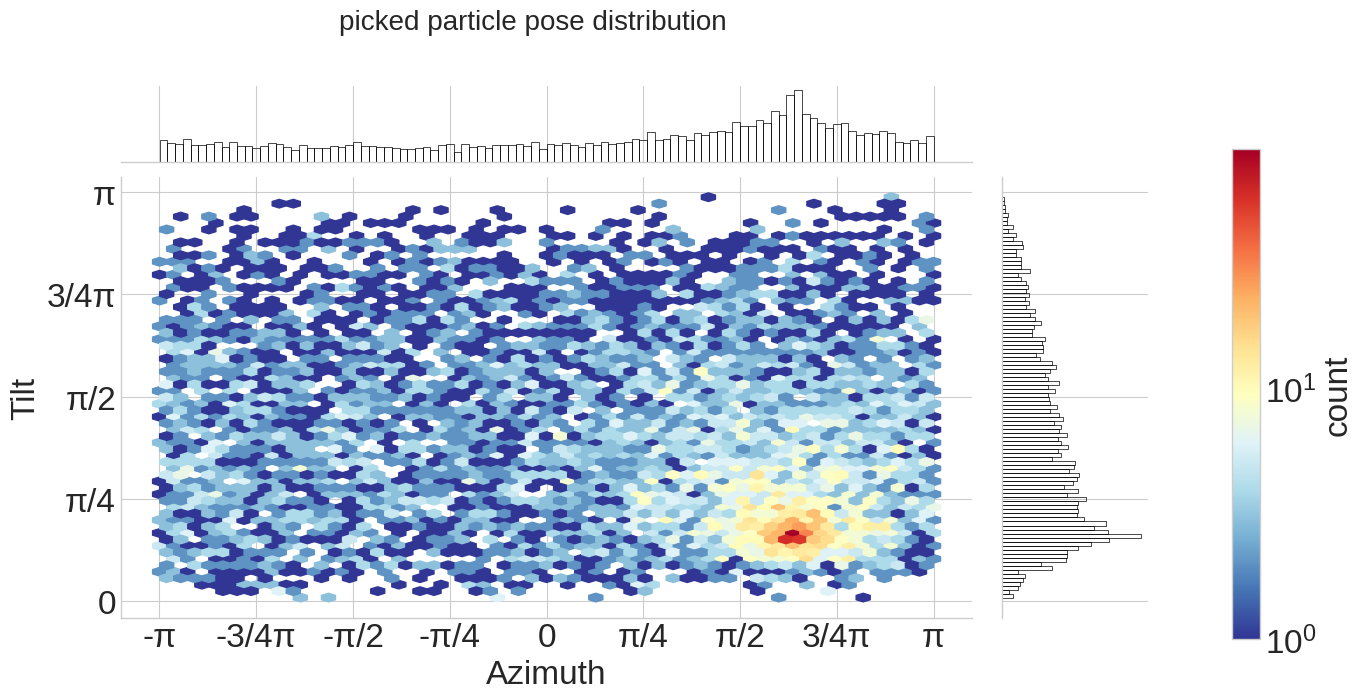

In [7]:
grid, _, _ = picked_pose_distribution_plot(
    df_picked=df_picked,
    metadata_filename=meta_files[0],
)
outfilename = os.path.join(figures_dir, f"picked_pose_distribution_{os.path.basename(meta_files[0])}.pdf")
# grid.savefig(outfilename, bbox_inches="tight")
print(f"saved figure to: {outfilename}")

## panel C
plotting ground-truth poses for covid spike trimer

saved figure to: /tudelft/mjoosten1/staff-umbrella/ajlab/MJ/projects/Roodmus/data/DE-Shaw_covid_spike_protein/20231116_DESRES-Trajectory_sarscov2-11021571-all-glueCA/figures/true_pose_distribution.pdf


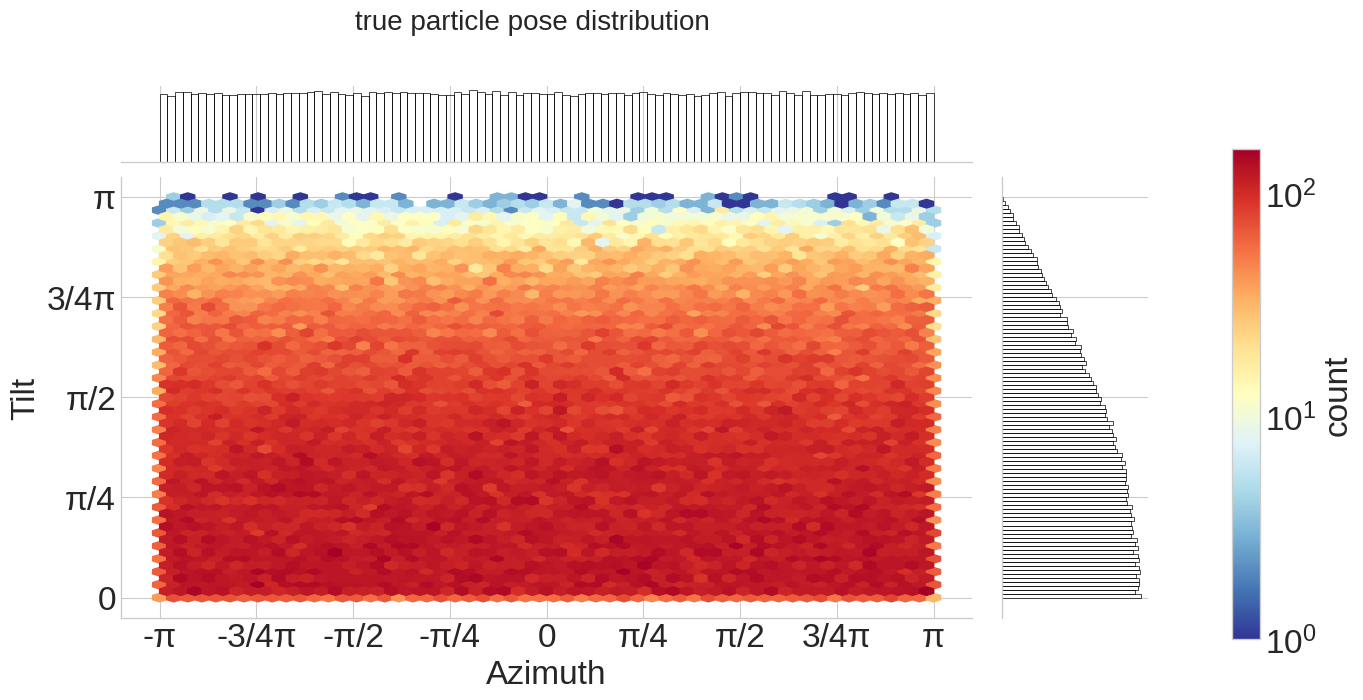

In [8]:
grid, _, _ = true_pose_distribution_plot(
    df_truth=df_truth,
)
outfilename = os.path.join(figures_dir, "true_pose_distribution.pdf")
# grid.savefig(outfilename, bbox_inches="tight")
print(f"saved figure to: {outfilename}")


## panel E
plotting particle picking for covid spike monomer

In [9]:
# data loading for spike monomer
### data loading (6xm5 steered MD)
project_dir = "/home/mjoosten1/projects/roodmus/data/6xm5_steered_Roodmus_2"
config_dir = os.path.join(project_dir, "mrc")
figures_dir = os.path.join(project_dir, "figures")
meta_files = [
    os.path.join(project_dir, "cryoSPARC", "J508_picked_particles.cs"), # blob picker
    os.path.join(project_dir, "cryoSPARC", "J509_extracted_particles.cs"), # filtering
    os.path.join(project_dir, "cryoSPARC", "J513_passthrough_particles_selected.cs"), # 2D class selection
    os.path.join(project_dir, "cryoSPARC", "J515_topaz_picked_particles.cs"), # topaz picker
    os.path.join(project_dir, "cryoSPARC", "J518_050_particles.cs"), # 2D classification 2
    os.path.join(project_dir, "cryoSPARC", "J519_passthrough_particles_class_0.cs"), # ab initio class 0
    os.path.join(project_dir, "cryoSPARC", "J519_passthrough_particles_class_1.cs"), # ab initio class 1
    os.path.join(project_dir, "cryoSPARC", "J519_passthrough_particles_class_2.cs"), # ab initio class 2
    os.path.join(project_dir, "cryoSPARC", "J519_passthrough_particles_class_3.cs"), # ab initio class 3
    os.path.join(project_dir, "cryoSPARC", "J523_passthrough_particles.cs"), # homogneous refinement
]

jobtypes = {
    os.path.join(project_dir, "cryoSPARC", "J508_picked_particles.cs"): "blob_picker",
    os.path.join(project_dir, "cryoSPARC", "J509_extracted_particles.cs"): "filtering",
    os.path.join(project_dir, "cryoSPARC", "J513_passthrough_particles_selected.cs"): "2D_class_selection",
    os.path.join(project_dir, "cryoSPARC", "J515_topaz_picked_particles.cs"): "topaz_picker",
    os.path.join(project_dir, "cryoSPARC", "J518_050_particles.cs"): "2D_classification_2",
    os.path.join(project_dir, "cryoSPARC", "J519_passthrough_particles_class_0.cs"): "ab_initio_class_0",
    os.path.join(project_dir, "cryoSPARC", "J519_passthrough_particles_class_1.cs"): "ab_initio_class_1",
    os.path.join(project_dir, "cryoSPARC", "J519_passthrough_particles_class_2.cs"): "ab_initio_class_2",
    os.path.join(project_dir, "cryoSPARC", "J519_passthrough_particles_class_3.cs"): "ab_initio_class_3",
    os.path.join(project_dir, "cryoSPARC", "J523_passthrough_particles.cs"): "homogeneous_refinement",
}

particle_diameter = 100 # approximate particle diameter in Angstroms
ugraph_shape = (4000, 4000) # shape of the micrograph in pixels. Only needs to be given if the metadata file is a .star file
verbose = True # prints out progress statements
ignore_missing_files = True # if .mrc files are missing, the analysis will still be performed
enable_tqdm = True # enables tqdm progress bars

for i, meta_file in enumerate(meta_files):
    if i == 0:
        analysis = load_data(meta_file, config_dir, particle_diameter, ugraph_shape=ugraph_shape, verbose=verbose, enable_tqdm=enable_tqdm, ignore_missing_files=ignore_missing_files) # creates the class
    else:
        analysis.add_data(meta_file, config_dir, verbose=verbose) # updates the class with the next metadata file
df_picked = pd.DataFrame(analysis.results_picking)
df_truth = pd.DataFrame(analysis.results_truth)
df_precision, df_picked = analysis.compute_precision(df_picked, df_truth, verbose=verbose)
print(f"mean precision: {df_precision['precision'].mean()}")
print(f"mean recall: {df_precision['recall'].mean()}")


loading metadata from /home/mjoosten1/projects/roodmus/data/6xm5_steered_Roodmus_2/cryoSPARC/J508_picked_particles.cs...
loaded metadata from /home/mjoosten1/projects/roodmus/data/6xm5_steered_Roodmus_2/cryoSPARC/J508_picked_particles.cs. determined file type: cs


Dictionaries now contain 1968039 reconstructed particles
added 1968039 particles from /home/mjoosten1/projects/roodmus/data/6xm5_steered_Roodmus_2/cryoSPARC/J508_picked_particles.cs


loading truth data: 100%|██████████| 800/800 [06:52<00:00,  1.94it/s, micrograph=000799.mrc]


Loaded ground-truth particle positions from config files
Dictionaries now contain 1968039 particles and 200000 true particles
Added 200000 particles from /home/mjoosten1/projects/roodmus/data/6xm5_steered_Roodmus_2/mrc
loading metadata from /home/mjoosten1/projects/roodmus/data/6xm5_steered_Roodmus_2/cryoSPARC/J509_extracted_particles.cs...
loaded metadata from /home/mjoosten1/projects/roodmus/data/6xm5_steered_Roodmus_2/cryoSPARC/J509_extracted_particles.cs. determined file type: cs
checking if ugraphs exist...


Dictionaries now contain 2390899 reconstructed particles
added 422860 particles from /home/mjoosten1/projects/roodmus/data/6xm5_steered_Roodmus_2/cryoSPARC/J509_extracted_particles.cs
loading metadata from /home/mjoosten1/projects/roodmus/data/6xm5_steered_Roodmus_2/cryoSPARC/J513_passthrough_particles_selected.cs...
loaded metadata from /home/mjoosten1/projects/roodmus/data/6xm5_steered_Roodmus_2/cryoSPARC/J513_passthrough_particles_selected.cs. determined file type: cs
chec

computing precision: 100%|██████████| 8000/8000 [12:45<00:00, 10.45it/s, precision=0.794, recall=0.837, multiplicity=0.912] 


time taken to compute precision: 774.7178816795349
mean precision: 0.7383408552298354
mean recall: 0.5706462714368359


saved figure to: /home/mjoosten1/projects/roodmus/data/6xm5_steered_Roodmus_2/figures/precision.pdf
saved figure to: /home/mjoosten1/projects/roodmus/data/6xm5_steered_Roodmus_2/figures/recall.pdf


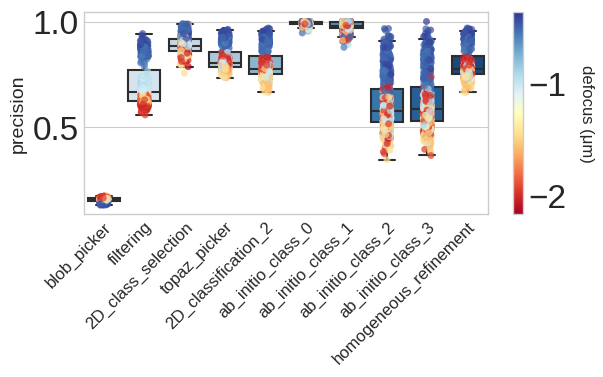

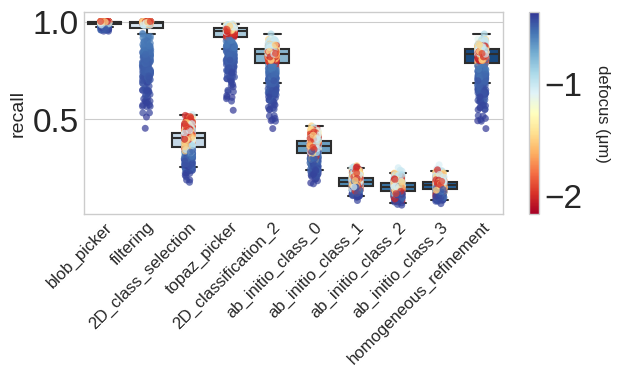

In [10]:
### plot boxplot for precision and recall
order = []
for r in meta_files:
    if type(r) == str:
        order.append(r)
    else:
        order.append(r[0])  
fig, ax = plot_precision(df_precision, jobtypes, order)
xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, fontsize=12)
ax.set_title("")
fig.set_size_inches(7, 7)

fig.savefig(os.path.join(figures_dir, "precision.pdf"), bbox_inches="tight")
print(f"saved figure to: {os.path.join(figures_dir, 'precision.pdf')}")


fig, ax = plot_recall(df_precision, jobtypes, order)
xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, fontsize=12)
ax.set_title("")
fig.set_size_inches(7, 7)

# fig.savefig(os.path.join(figures_dir, "recall.pdf"), bbox_inches="tight")
print(f"saved figure to: {os.path.join(figures_dir, 'recall.pdf')}")
